# Triple Stratified KFold CV with TFRecords
This is a simple starter notebook for Kaggle's Melanoma Comp showing triple stratifed KFold with TFRecords. Triple stratified KFold is explained [here][2]. There are many configuration variables below to allow you to experiment. Use either GPU or TPU. You can control which size images are loaded, which efficientNets are used, and whether external data is used. You can experiment with different data augmentation, model architecture, loss, optimizers, and learning schedules. The TFRecords contain meta data, so you can input that into your CNN too. 


# Initialize Environment

In [1]:
!pip install -q efficientnet >> /dev/null

In [2]:
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import glorot_uniform


2022-02-02 10:22:30.488244: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-02 10:22:30.488378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Configuration
In order to be a proper cross validation with a meaningful overall CV score (aligned with LB score), **you need to choose the same** `IMG_SIZES`, `INC2019`, `INC2018`, and `EFF_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds. 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [4]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384,384,384,384,384]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [15]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...


2022-02-02 10:22:47.380209: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-02 10:22:47.383247: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-02 10:22:47.383284: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-02 10:22:47.383365: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b40954784054): /proc/driver/nvidia/version does not exist
2022-02-02 10:22:47.386279: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 


In [6]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

2022-02-02 10:23:18.815145: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:23:19.022171: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.


In [7]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [8]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [9]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [11]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Step 3: Build Models
change backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [12]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]
from tensorflow.keras import Model 
def build_model_efn(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    base_model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    headModel = base_model.output
    headModel = Flatten()(headModel)
    headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
    headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
    headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
    model = Model(inputs=base_model.input, outputs=headModel)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    
    return model


# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. 

In [13]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
The model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above.

#########################
#### FOLD 1


2022-02-02 10:24:53.236111: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:53.377806: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:53.528799: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:53.667403: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:53.807799: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#### Using 2018+2017 external data
#########################


2022-02-02 10:24:56.565111: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:56.699818: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:56.836351: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:24:56.971471: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Training...
Epoch 1/15
142/142 [==============================] - 148s 664ms/step - loss: 0.3003 - auc: 0.6301 - val_loss: 0.1791 - val_auc: 0.6721


2022-02-02 10:27:36.667634: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 19665, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643797656.664110086","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 19665, Output num: 1","grpc_status":3}


Epoch 2/15
142/142 [==============================] - 78s 549ms/step - loss: 0.2817 - auc: 0.6570 - val_loss: 0.1776 - val_auc: 0.6657
Epoch 3/15
142/142 [==============================] - 79s 557ms/step - loss: 0.2571 - auc: 0.7548 - val_loss: 0.2186 - val_auc: 0.7306
Epoch 4/15
142/142 [==============================] - 79s 555ms/step - loss: 0.2528 - auc: 0.7758 - val_loss: 0.1788 - val_auc: 0.7085
Epoch 5/15
142/142 [==============================] - 78s 552ms/step - loss: 0.2501 - auc: 0.8028 - val_loss: 0.1901 - val_auc: 0.7037
Epoch 6/15
142/142 [==============================] - 77s 545ms/step - loss: 0.2491 - auc: 0.8139 - val_loss: 0.2582 - val_auc: 0.5568
Epoch 7/15
142/142 [==============================] - 77s 545ms/step - loss: 0.2425 - auc: 0.8213 - val_loss: 0.1792 - val_auc: 0.7508
Epoch 8/15
142/142 [==============================] - 77s 545ms/step - loss: 0.2389 - auc: 0.8325 - val_loss: 0.1942 - val_auc: 0.7420
Epoch 9/15
142/142 [==============================] - 7

2022-02-02 10:48:10.485957: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 79511, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643798890.485644211","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 79511, Output num: 0","grpc_status":3}


Predicting Test with TTA...
117/117 [==============================] - 154s 1s/step
#### FOLD 1 OOF AUC without TTA = 0.821, with TTA = 0.839


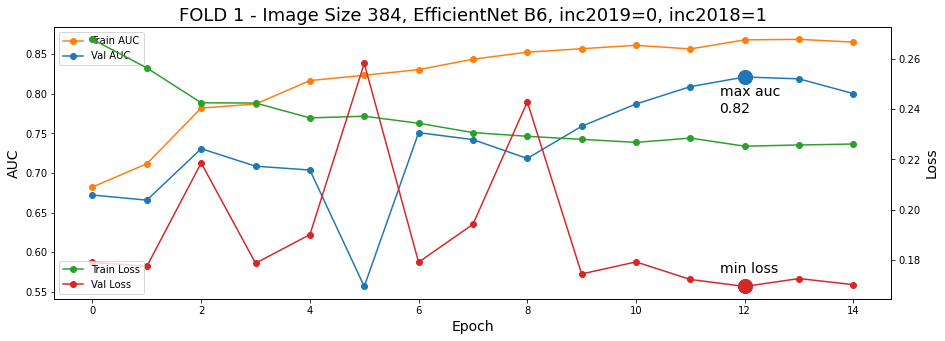

#########################
#### FOLD 2


2022-02-02 10:51:05.393811: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:05.542567: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:05.679589: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:05.814431: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:05.956414: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#### Using 2018+2017 external data
#########################


2022-02-02 10:51:08.734337: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:08.877902: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:09.013757: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 10:51:09.150095: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Training...
Epoch 1/15
142/142 [==============================] - 146s 647ms/step - loss: 0.2917 - auc: 0.6331 - val_loss: 0.1853 - val_auc: 0.6854


2022-02-02 10:53:42.863528: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 112687, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643799222.863433722","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 112687, Output num: 1","grpc_status":3}


Epoch 2/15
142/142 [==============================] - 77s 544ms/step - loss: 0.3495 - auc: 0.6008 - val_loss: 0.1738 - val_auc: 0.6407
Epoch 3/15
142/142 [==============================] - 79s 555ms/step - loss: 0.2647 - auc: 0.7315 - val_loss: 0.1837 - val_auc: 0.7156
Epoch 4/15
142/142 [==============================] - 78s 548ms/step - loss: 0.2601 - auc: 0.7563 - val_loss: 0.1807 - val_auc: 0.7025
Epoch 5/15
142/142 [==============================] - 78s 548ms/step - loss: 0.2490 - auc: 0.7943 - val_loss: 0.1815 - val_auc: 0.7229
Epoch 6/15
142/142 [==============================] - 78s 552ms/step - loss: 0.2452 - auc: 0.8122 - val_loss: 0.3007 - val_auc: 0.4900
Epoch 7/15
142/142 [==============================] - 78s 548ms/step - loss: 0.2403 - auc: 0.8307 - val_loss: 0.1849 - val_auc: 0.7675
Epoch 8/15
142/142 [==============================] - 77s 545ms/step - loss: 0.2338 - auc: 0.8452 - val_loss: 0.2147 - val_auc: 0.7230
Epoch 9/15
142/142 [==============================] - 7

2022-02-02 11:14:06.161918: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 168241, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643800446.161753518","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 168241, Output num: 1","grpc_status":3}


Predicting Test with TTA...
117/117 [==============================] - 154s 1s/step
#### FOLD 2 OOF AUC without TTA = 0.811, with TTA = 0.829


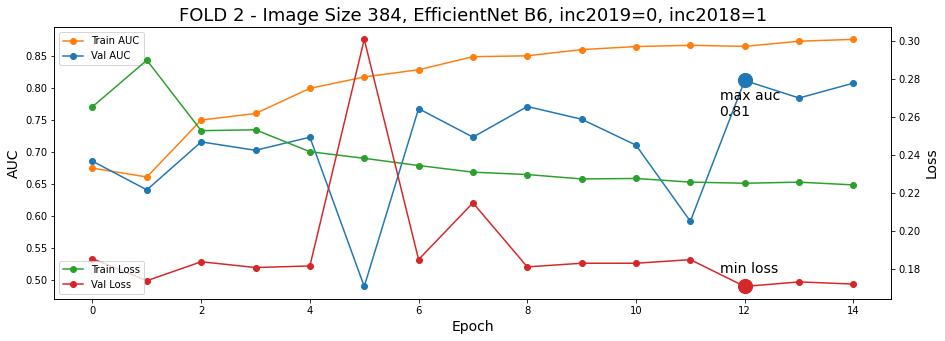

#########################
#### FOLD 3


2022-02-02 11:17:00.357433: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:00.504843: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:00.642179: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:00.787085: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:00.925348: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#### Using 2018+2017 external data
#########################


2022-02-02 11:17:03.739034: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:03.868962: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:04.014177: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:17:04.148883: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Training...
Epoch 1/15
142/142 [==============================] - 143s 601ms/step - loss: 0.3127 - auc: 0.6226 - val_loss: 0.1833 - val_auc: 0.6762


2022-02-02 11:19:34.056206: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 207613, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643800774.056048463","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 207613, Output num: 1","grpc_status":3}


Epoch 2/15
142/142 [==============================] - 77s 541ms/step - loss: 0.3017 - auc: 0.6480 - val_loss: 0.1725 - val_auc: 0.7076
Epoch 3/15
142/142 [==============================] - 78s 547ms/step - loss: 0.2599 - auc: 0.7520 - val_loss: 0.1809 - val_auc: 0.7526
Epoch 4/15
142/142 [==============================] - 77s 543ms/step - loss: 0.2544 - auc: 0.7841 - val_loss: 0.1975 - val_auc: 0.7502
Epoch 5/15
142/142 [==============================] - 77s 542ms/step - loss: 0.2528 - auc: 0.7943 - val_loss: 0.1978 - val_auc: 0.7535
Epoch 6/15
142/142 [==============================] - 77s 543ms/step - loss: 0.2535 - auc: 0.8106 - val_loss: 0.2150 - val_auc: 0.6961
Epoch 7/15
142/142 [==============================] - 77s 546ms/step - loss: 0.2476 - auc: 0.8248 - val_loss: 0.1821 - val_auc: 0.8081
Epoch 8/15
142/142 [==============================] - 78s 548ms/step - loss: 0.2431 - auc: 0.8420 - val_loss: 0.1848 - val_auc: 0.8477
Epoch 9/15
142/142 [==============================] - 7

2022-02-02 11:40:00.523483: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 267491, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643802000.523359875","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 267491, Output num: 0","grpc_status":3}


Predicting Test with TTA...
117/117 [==============================] - 156s 1s/step
#### FOLD 3 OOF AUC without TTA = 0.859, with TTA = 0.858


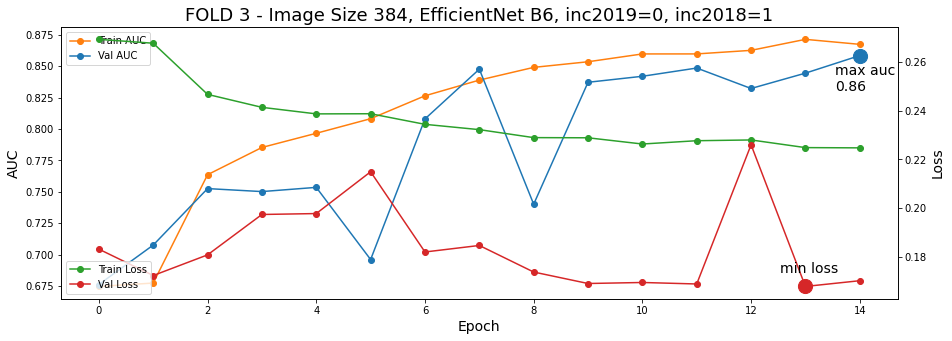

#########################
#### FOLD 4


2022-02-02 11:42:56.452432: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:42:56.591224: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:42:56.722569: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:42:56.857262: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:42:56.992768: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#### Using 2018+2017 external data
#########################


2022-02-02 11:42:59.752852: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:42:59.890925: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:43:00.027229: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 11:43:00.159838: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Training...
Epoch 1/15
142/142 [==============================] - 142s 605ms/step - loss: 0.3083 - auc: 0.6334 - val_loss: 0.1968 - val_auc: 0.6836


2022-02-02 11:45:29.700466: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 306896, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643802329.700391111","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 306896, Output num: 0","grpc_status":3}


Epoch 2/15
142/142 [==============================] - 78s 553ms/step - loss: 0.2820 - auc: 0.6841 - val_loss: 0.1730 - val_auc: 0.6722
Epoch 3/15
142/142 [==============================] - 77s 544ms/step - loss: 0.2628 - auc: 0.7461 - val_loss: 0.1868 - val_auc: 0.7028
Epoch 4/15
142/142 [==============================] - 79s 553ms/step - loss: 0.2580 - auc: 0.7768 - val_loss: 0.2765 - val_auc: 0.5904
Epoch 5/15
142/142 [==============================] - 78s 549ms/step - loss: 0.2556 - auc: 0.7938 - val_loss: 0.2108 - val_auc: 0.6556
Epoch 6/15
142/142 [==============================] - 78s 553ms/step - loss: 0.2545 - auc: 0.8094 - val_loss: 0.2044 - val_auc: 0.6855
Epoch 7/15
142/142 [==============================] - 78s 549ms/step - loss: 0.2475 - auc: 0.8291 - val_loss: 0.1918 - val_auc: 0.7188
Epoch 8/15
142/142 [==============================] - 78s 551ms/step - loss: 0.2473 - auc: 0.8364 - val_loss: 0.2372 - val_auc: 0.7479
Epoch 9/15
142/142 [==============================] - 7

2022-02-02 12:06:10.671273: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 366656, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643803570.671070059","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 366656, Output num: 1","grpc_status":3}


Predicting Test with TTA...
117/117 [==============================] - 161s 1s/step
#### FOLD 4 OOF AUC without TTA = 0.805, with TTA = 0.812


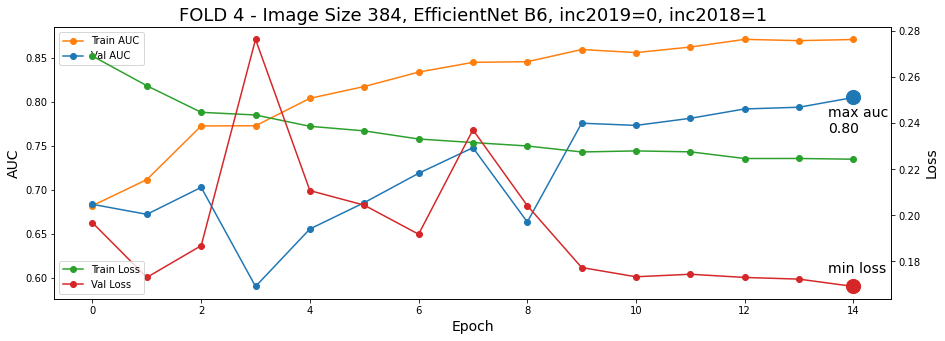

#########################
#### FOLD 5


2022-02-02 12:09:11.118539: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:11.262671: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:11.403136: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:11.541161: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:11.680016: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#### Using 2018+2017 external data
#########################


2022-02-02 12:09:14.397272: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:14.534524: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:14.671758: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-02 12:09:14.804957: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Training...
Epoch 1/15
142/142 [==============================] - 144s 615ms/step - loss: 0.3044 - auc: 0.5958 - val_loss: 0.1960 - val_auc: 0.7225


2022-02-02 12:11:46.114356: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 405990, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643803906.114012690","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 405990, Output num: 1","grpc_status":3}


Epoch 2/15
142/142 [==============================] - 80s 562ms/step - loss: 0.3057 - auc: 0.6624 - val_loss: 0.1753 - val_auc: 0.6408
Epoch 3/15
142/142 [==============================] - 80s 564ms/step - loss: 0.2523 - auc: 0.7666 - val_loss: 0.1955 - val_auc: 0.7226
Epoch 4/15
142/142 [==============================] - 80s 567ms/step - loss: 0.2520 - auc: 0.7762 - val_loss: 0.2123 - val_auc: 0.6991
Epoch 5/15
142/142 [==============================] - 80s 566ms/step - loss: 0.2444 - auc: 0.8181 - val_loss: 0.1831 - val_auc: 0.7562
Epoch 6/15
142/142 [==============================] - 80s 564ms/step - loss: 0.2599 - auc: 0.7742 - val_loss: 0.1807 - val_auc: 0.7824
Epoch 7/15
142/142 [==============================] - 80s 560ms/step - loss: 0.2425 - auc: 0.8201 - val_loss: 0.1841 - val_auc: 0.7765
Epoch 8/15
142/142 [==============================] - 79s 558ms/step - loss: 0.2366 - auc: 0.8375 - val_loss: 0.1733 - val_auc: 0.8031
Epoch 9/15
142/142 [==============================] - 7

2022-02-02 12:32:44.204342: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 468018, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1643805164.204146622","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 468018, Output num: 0","grpc_status":3}


Predicting Test with TTA...
117/117 [==============================] - 160s 1s/step
#### FOLD 5 OOF AUC without TTA = 0.838, with TTA = 0.842


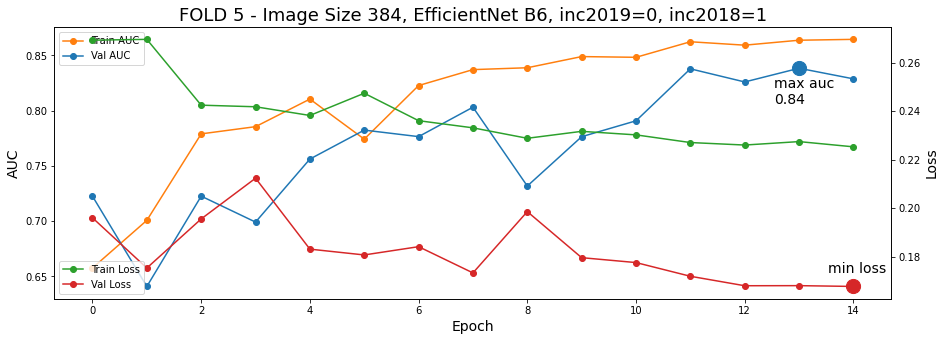

Time needed for training: 7852.850895643234


In [14]:
start = time.time()
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    #print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
    #      (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        #model = build_model_efn(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        model = ResNet50(input_shape=(IMG_SIZES[fold], IMG_SIZES[fold], 3))
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    try:
        model.save('Resnet_model.h5')
    except:
        pass
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  
end = time.time()
print("Time needed for training:",end - start)

## Calculate OOF AUC
The OOF (out of fold) 

In [15]:
from sklearn.metrics import classification_report
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)
preds= []
for pred in oof:
    if pred > 0.5:
        preds.append(1)
    else:
        preds.append(0)
target_names = ['benign', 'melanoma']
print(classification_report(true, preds, target_names=target_names))
# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.832
              precision    recall  f1-score   support

      benign       0.98      1.00      0.99     32111
    melanoma       0.50      0.01      0.01       581

    accuracy                           0.98     32692
   macro avg       0.74      0.50      0.50     32692
weighted avg       0.97      0.98      0.97     32692



,image_name,target,pred,fold
0,ISIC_2637011,0,0.045635,0
1,ISIC_0076262,0,0.025766,0
2,ISIC_0074268,0,0.034990,0
3,ISIC_0015719,0,0.037749,0
4,ISIC_0082543,0,0.024359,0
